In [1]:
%%time
import os

import pandas as pd
from pandas.core.groupby import DataFrameGroupBy
from dask.diagnostics import ProgressBar
from tqdm.dask import TqdmCallback

from shared_code.utility.schemas.pyarrow_schema import schema
from shared_code.utility.spark.set_environ import set_azure_env

cb = TqdmCallback(desc="global")
cb.register()

set_azure_env()

from shared_code.utility.storage.azure_file_storage import AzureFileStorageAdapter

file_system = AzureFileStorageAdapter('data').get_file_storage()


CPU times: total: 1.02 s
Wall time: 1.21 s


In [2]:
def filter_on_existing_thumbnail_path(x: object) -> bool:
	try:
		path = x['thumbnail_path']
		return os.path.exists(path)
	except:
		return False

In [3]:
def get_image_bytes(x: object) -> object:
	try:
		path = x['path']
		data = open(path, 'rb').read()
		return data
	except:
		return None

In [4]:
%%time
extant_data = pd.read_parquet("data/processed_raw_data.parquet", engine='pyarrow', filesystem=file_system)
display(extant_data)

,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,thumbnail_path,exists,curated
0,1000cej,CityPorn,OtterlyFoxy,New York in the fog,cars are parked on the side of the road in the...,7a8d96e378c15c8ab8440ac311f12c11,/r/CityPorn/comments/1000cej/new_york_in_the_fog/,https://i.redd.it/4emw5uldib9a1.jpg,4emw5uldib9a1.jpg,D:\data\images\CityPorn\4emw5uldib9a1.jpg,D:\data\images\CityPorn\thumbnail\4emw5uldib9a...,True,False
1,1000glf,AmIhotAF,toolate_sharkbait,Just looking for entertainment,blonde woman with blonde hair and tattoos on h...,e554c1ed7ffa2740436ac082068b2824,/r/AmIhotAF/comments/1000glf/just_looking_for_...,https://i.redd.it/4xyb1vgbjb9a1.jpg,4xyb1vgbjb9a1.jpg,D:\data\images\AmIhotAF\4xyb1vgbjb9a1.jpg,D:\data\images\AmIhotAF\thumbnail\4xyb1vgbjb9a...,True,False
2,1000j1n,greentext,trent8051,Anon wants Elon cut,a man with a beard and a beard sitting in fron...,1dec3dabb5e46cde01855d06089c287a,/r/greentext/comments/1000j1n/anon_wants_elon_...,https://i.redd.it/3mewbe0wjb9a1.jpg,3mewbe0wjb9a1.jpg,D:\data\images\greentext\3mewbe0wjb9a1.jpg,D:\data\images\greentext\thumbnail\3mewbe0wjb9...,True,False
3,1000mjs,spaceporn,MorningStar_imangi,Northern Lights above Lofoten,a view of a view of a large green and purple a...,2c39ce1290fba541abd0b004b09da6b2,/r/spaceporn/comments/1000mjs/northern_lights_...,https://i.redd.it/7s5aafaqkb9a1.jpg,7s5aafaqkb9a1.jpg,/data/images/spaceporn/7s5aafaqkb9a1.jpg,/data/images/spaceporn/thumbnail/7s5aafaqkb9a1...,True,False
4,1000qpd,spaceporn,MorningStar_imangi,Viking Lights,a scene of a boat is sitting on the shore of a...,0f72de47c69ff50eca5fa3990215f4ac,/r/spaceporn/comments/1000qpd/viking_lights/,https://i.redd.it/abojw7lqlb9a1.jpg,abojw7lqlb9a1.jpg,/data/images/spaceporn/abojw7lqlb9a1.jpg,/data/images/spaceporn/thumbnail/abojw7lqlb9a1...,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17077,11ajmf8,itookapicture,caue_st,ITAP of a little spider,there is a small insect on the red flowers in ...,2ea9dabac6e5e29fcabba6bb4e67d69c,/r/itookapicture/comments/11ajmf8/itap_of_a_li...,https://i.redd.it/7hda3drs64ka1.jpg,2ea9dabac6e5e29fcabba6bb4e67d69c.jpg,D:\data\images\itookapicture\2ea9dabac6e5e29fc...,D:\data\images\itookapicture\thumbnail\2ea9dab...,True,False
17078,11aijs3,itookapicture,Eirik100,ITAP of an old wall,a close up of a red and white fire hydrant wit...,3f2168df91d1ad5ee78e5cf14c947045,/r/itookapicture/comments/11aijs3/itap_of_an_o...,https://i.imgur.com/h17lyth.jpg,3f2168df91d1ad5ee78e5cf14c947045.jpg,D:\data\images\itookapicture\3f2168df91d1ad5ee...,D:\data\images\itookapicture\thumbnail\3f2168d...,True,False
17079,11aies8,itookapicture,WittilyOrder,ITAP of a buck and his bird in the morning mist,arafed image of a deer in the foggy morning,6230a5e6312b05a2728785e10c5f59bb,/r/itookapicture/comments/11aies8/itap_of_a_bu...,https://i.redd.it/gkugpkb9d2ka1.jpg,6230a5e6312b05a2728785e10c5f59bb.jpg,D:\data\images\itookapicture\6230a5e6312b05a27...,D:\data\images\itookapicture\thumbnail\6230a5e...,True,False
17080,11aibqx,itookapicture,Max_McAlpin,ITAP a Mountain in Niseko Japan,skiers on a ski slope with a mountain in the b...,2e670a882739afed75ed8c0883e89c78,/r/itookapicture/comments/11aibqx/itap_a_mount...,https://i.redd.it/b8k6tgc0u3ka1.jpg,2e670a882739afed75ed8c0883e89c78.jpg,D:\data\images\itookapicture\2e670a882739afed7...,D:\data\images\itookapicture\thumbnail\2e670a8...,True,False


CPU times: total: 250 ms
Wall time: 964 ms


CPU times: total: 2.05 s
Wall time: 8.69 s


<Axes: xlabel='subreddit'>

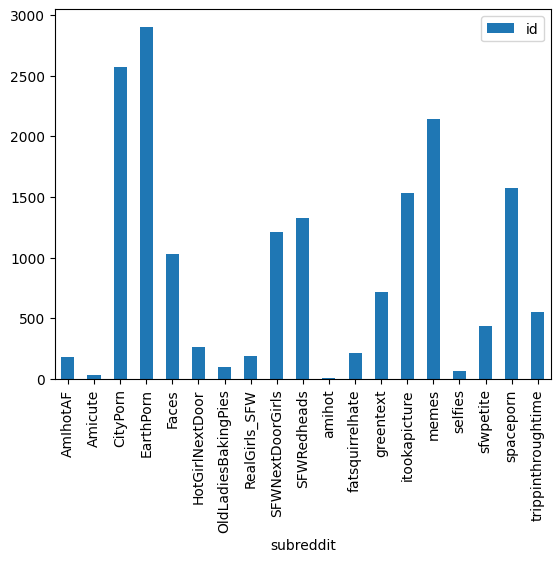

In [5]:
%%time
temp = extant_data.copy()
temp['exists'] = extant_data.apply(lambda x: filter_on_existing_thumbnail_path(x), axis=1)

temp = temp.where(lambda x: x['exists']).dropna(how='all').reset_index(drop=True)
temp = temp.where(lambda x: x['caption'] != "").dropna(how='all').reset_index(drop=True)

grouped: DataFrameGroupBy = temp \
	.where(lambda x: x['exists']) \
	.groupby('subreddit')

grouped.count().plot.bar(y='id')

In [6]:
%%time
display(temp)
temp.to_csv('processed_raw_data.csv', index=False)
file_system.put('processed_raw_data.csv','data/processed_raw_data.csv', overwrite=True)

,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,thumbnail_path,exists,curated
0,1000cej,CityPorn,OtterlyFoxy,New York in the fog,cars are parked on the side of the road in the...,7a8d96e378c15c8ab8440ac311f12c11,/r/CityPorn/comments/1000cej/new_york_in_the_fog/,https://i.redd.it/4emw5uldib9a1.jpg,4emw5uldib9a1.jpg,D:\data\images\CityPorn\4emw5uldib9a1.jpg,D:\data\images\CityPorn\thumbnail\4emw5uldib9a...,True,False
1,1000glf,AmIhotAF,toolate_sharkbait,Just looking for entertainment,blonde woman with blonde hair and tattoos on h...,e554c1ed7ffa2740436ac082068b2824,/r/AmIhotAF/comments/1000glf/just_looking_for_...,https://i.redd.it/4xyb1vgbjb9a1.jpg,4xyb1vgbjb9a1.jpg,D:\data\images\AmIhotAF\4xyb1vgbjb9a1.jpg,D:\data\images\AmIhotAF\thumbnail\4xyb1vgbjb9a...,True,False
2,1000j1n,greentext,trent8051,Anon wants Elon cut,a man with a beard and a beard sitting in fron...,1dec3dabb5e46cde01855d06089c287a,/r/greentext/comments/1000j1n/anon_wants_elon_...,https://i.redd.it/3mewbe0wjb9a1.jpg,3mewbe0wjb9a1.jpg,D:\data\images\greentext\3mewbe0wjb9a1.jpg,D:\data\images\greentext\thumbnail\3mewbe0wjb9...,True,False
3,1000mjs,spaceporn,MorningStar_imangi,Northern Lights above Lofoten,a view of a view of a large green and purple a...,2c39ce1290fba541abd0b004b09da6b2,/r/spaceporn/comments/1000mjs/northern_lights_...,https://i.redd.it/7s5aafaqkb9a1.jpg,7s5aafaqkb9a1.jpg,/data/images/spaceporn/7s5aafaqkb9a1.jpg,/data/images/spaceporn/thumbnail/7s5aafaqkb9a1...,True,False
4,1000qpd,spaceporn,MorningStar_imangi,Viking Lights,a scene of a boat is sitting on the shore of a...,0f72de47c69ff50eca5fa3990215f4ac,/r/spaceporn/comments/1000qpd/viking_lights/,https://i.redd.it/abojw7lqlb9a1.jpg,abojw7lqlb9a1.jpg,/data/images/spaceporn/abojw7lqlb9a1.jpg,/data/images/spaceporn/thumbnail/abojw7lqlb9a1...,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17020,11ajmf8,itookapicture,caue_st,ITAP of a little spider,there is a small insect on the red flowers in ...,2ea9dabac6e5e29fcabba6bb4e67d69c,/r/itookapicture/comments/11ajmf8/itap_of_a_li...,https://i.redd.it/7hda3drs64ka1.jpg,2ea9dabac6e5e29fcabba6bb4e67d69c.jpg,D:\data\images\itookapicture\2ea9dabac6e5e29fc...,D:\data\images\itookapicture\thumbnail\2ea9dab...,True,False
17021,11aijs3,itookapicture,Eirik100,ITAP of an old wall,a close up of a red and white fire hydrant wit...,3f2168df91d1ad5ee78e5cf14c947045,/r/itookapicture/comments/11aijs3/itap_of_an_o...,https://i.imgur.com/h17lyth.jpg,3f2168df91d1ad5ee78e5cf14c947045.jpg,D:\data\images\itookapicture\3f2168df91d1ad5ee...,D:\data\images\itookapicture\thumbnail\3f2168d...,True,False
17022,11aies8,itookapicture,WittilyOrder,ITAP of a buck and his bird in the morning mist,arafed image of a deer in the foggy morning,6230a5e6312b05a2728785e10c5f59bb,/r/itookapicture/comments/11aies8/itap_of_a_bu...,https://i.redd.it/gkugpkb9d2ka1.jpg,6230a5e6312b05a2728785e10c5f59bb.jpg,D:\data\images\itookapicture\6230a5e6312b05a27...,D:\data\images\itookapicture\thumbnail\6230a5e...,True,False
17023,11aibqx,itookapicture,Max_McAlpin,ITAP a Mountain in Niseko Japan,skiers on a ski slope with a mountain in the b...,2e670a882739afed75ed8c0883e89c78,/r/itookapicture/comments/11aibqx/itap_a_mount...,https://i.redd.it/b8k6tgc0u3ka1.jpg,2e670a882739afed75ed8c0883e89c78.jpg,D:\data\images\itookapicture\2e670a882739afed7...,D:\data\images\itookapicture\thumbnail\2e670a8...,True,False


CPU times: total: 203 ms
Wall time: 3.59 s


[None]

In [7]:
final = pd.read_csv(file_system.open('data/processed_raw_data.csv'))
display(final)
final.to_parquet("data/processed_raw_data.parquet", engine='pyarrow', filesystem=file_system, schema=schema)

,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,thumbnail_path,exists,curated
0,1000cej,CityPorn,OtterlyFoxy,New York in the fog,cars are parked on the side of the road in the...,7a8d96e378c15c8ab8440ac311f12c11,/r/CityPorn/comments/1000cej/new_york_in_the_fog/,https://i.redd.it/4emw5uldib9a1.jpg,4emw5uldib9a1.jpg,D:\data\images\CityPorn\4emw5uldib9a1.jpg,D:\data\images\CityPorn\thumbnail\4emw5uldib9a...,True,False
1,1000glf,AmIhotAF,toolate_sharkbait,Just looking for entertainment,blonde woman with blonde hair and tattoos on h...,e554c1ed7ffa2740436ac082068b2824,/r/AmIhotAF/comments/1000glf/just_looking_for_...,https://i.redd.it/4xyb1vgbjb9a1.jpg,4xyb1vgbjb9a1.jpg,D:\data\images\AmIhotAF\4xyb1vgbjb9a1.jpg,D:\data\images\AmIhotAF\thumbnail\4xyb1vgbjb9a...,True,False
2,1000j1n,greentext,trent8051,Anon wants Elon cut,a man with a beard and a beard sitting in fron...,1dec3dabb5e46cde01855d06089c287a,/r/greentext/comments/1000j1n/anon_wants_elon_...,https://i.redd.it/3mewbe0wjb9a1.jpg,3mewbe0wjb9a1.jpg,D:\data\images\greentext\3mewbe0wjb9a1.jpg,D:\data\images\greentext\thumbnail\3mewbe0wjb9...,True,False
3,1000mjs,spaceporn,MorningStar_imangi,Northern Lights above Lofoten,a view of a view of a large green and purple a...,2c39ce1290fba541abd0b004b09da6b2,/r/spaceporn/comments/1000mjs/northern_lights_...,https://i.redd.it/7s5aafaqkb9a1.jpg,7s5aafaqkb9a1.jpg,/data/images/spaceporn/7s5aafaqkb9a1.jpg,/data/images/spaceporn/thumbnail/7s5aafaqkb9a1...,True,False
4,1000qpd,spaceporn,MorningStar_imangi,Viking Lights,a scene of a boat is sitting on the shore of a...,0f72de47c69ff50eca5fa3990215f4ac,/r/spaceporn/comments/1000qpd/viking_lights/,https://i.redd.it/abojw7lqlb9a1.jpg,abojw7lqlb9a1.jpg,/data/images/spaceporn/abojw7lqlb9a1.jpg,/data/images/spaceporn/thumbnail/abojw7lqlb9a1...,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17020,11ajmf8,itookapicture,caue_st,ITAP of a little spider,there is a small insect on the red flowers in ...,2ea9dabac6e5e29fcabba6bb4e67d69c,/r/itookapicture/comments/11ajmf8/itap_of_a_li...,https://i.redd.it/7hda3drs64ka1.jpg,2ea9dabac6e5e29fcabba6bb4e67d69c.jpg,D:\data\images\itookapicture\2ea9dabac6e5e29fc...,D:\data\images\itookapicture\thumbnail\2ea9dab...,True,False
17021,11aijs3,itookapicture,Eirik100,ITAP of an old wall,a close up of a red and white fire hydrant wit...,3f2168df91d1ad5ee78e5cf14c947045,/r/itookapicture/comments/11aijs3/itap_of_an_o...,https://i.imgur.com/h17lyth.jpg,3f2168df91d1ad5ee78e5cf14c947045.jpg,D:\data\images\itookapicture\3f2168df91d1ad5ee...,D:\data\images\itookapicture\thumbnail\3f2168d...,True,False
17022,11aies8,itookapicture,WittilyOrder,ITAP of a buck and his bird in the morning mist,arafed image of a deer in the foggy morning,6230a5e6312b05a2728785e10c5f59bb,/r/itookapicture/comments/11aies8/itap_of_a_bu...,https://i.redd.it/gkugpkb9d2ka1.jpg,6230a5e6312b05a2728785e10c5f59bb.jpg,D:\data\images\itookapicture\6230a5e6312b05a27...,D:\data\images\itookapicture\thumbnail\6230a5e...,True,False
17023,11aibqx,itookapicture,Max_McAlpin,ITAP a Mountain in Niseko Japan,skiers on a ski slope with a mountain in the b...,2e670a882739afed75ed8c0883e89c78,/r/itookapicture/comments/11aibqx/itap_a_mount...,https://i.redd.it/b8k6tgc0u3ka1.jpg,2e670a882739afed75ed8c0883e89c78.jpg,D:\data\images\itookapicture\2e670a882739afed7...,D:\data\images\itookapicture\thumbnail\2e670a8...,True,False


In [8]:
check = pd.read_parquet("data/processed_raw_data.parquet", engine='pyarrow', filesystem=file_system)
display(check)

,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,thumbnail_path,exists,curated
0,1000cej,CityPorn,OtterlyFoxy,New York in the fog,cars are parked on the side of the road in the...,7a8d96e378c15c8ab8440ac311f12c11,/r/CityPorn/comments/1000cej/new_york_in_the_fog/,https://i.redd.it/4emw5uldib9a1.jpg,4emw5uldib9a1.jpg,D:\data\images\CityPorn\4emw5uldib9a1.jpg,D:\data\images\CityPorn\thumbnail\4emw5uldib9a...,True,False
1,1000glf,AmIhotAF,toolate_sharkbait,Just looking for entertainment,blonde woman with blonde hair and tattoos on h...,e554c1ed7ffa2740436ac082068b2824,/r/AmIhotAF/comments/1000glf/just_looking_for_...,https://i.redd.it/4xyb1vgbjb9a1.jpg,4xyb1vgbjb9a1.jpg,D:\data\images\AmIhotAF\4xyb1vgbjb9a1.jpg,D:\data\images\AmIhotAF\thumbnail\4xyb1vgbjb9a...,True,False
2,1000j1n,greentext,trent8051,Anon wants Elon cut,a man with a beard and a beard sitting in fron...,1dec3dabb5e46cde01855d06089c287a,/r/greentext/comments/1000j1n/anon_wants_elon_...,https://i.redd.it/3mewbe0wjb9a1.jpg,3mewbe0wjb9a1.jpg,D:\data\images\greentext\3mewbe0wjb9a1.jpg,D:\data\images\greentext\thumbnail\3mewbe0wjb9...,True,False
3,1000mjs,spaceporn,MorningStar_imangi,Northern Lights above Lofoten,a view of a view of a large green and purple a...,2c39ce1290fba541abd0b004b09da6b2,/r/spaceporn/comments/1000mjs/northern_lights_...,https://i.redd.it/7s5aafaqkb9a1.jpg,7s5aafaqkb9a1.jpg,/data/images/spaceporn/7s5aafaqkb9a1.jpg,/data/images/spaceporn/thumbnail/7s5aafaqkb9a1...,True,False
4,1000qpd,spaceporn,MorningStar_imangi,Viking Lights,a scene of a boat is sitting on the shore of a...,0f72de47c69ff50eca5fa3990215f4ac,/r/spaceporn/comments/1000qpd/viking_lights/,https://i.redd.it/abojw7lqlb9a1.jpg,abojw7lqlb9a1.jpg,/data/images/spaceporn/abojw7lqlb9a1.jpg,/data/images/spaceporn/thumbnail/abojw7lqlb9a1...,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17020,11ajmf8,itookapicture,caue_st,ITAP of a little spider,there is a small insect on the red flowers in ...,2ea9dabac6e5e29fcabba6bb4e67d69c,/r/itookapicture/comments/11ajmf8/itap_of_a_li...,https://i.redd.it/7hda3drs64ka1.jpg,2ea9dabac6e5e29fcabba6bb4e67d69c.jpg,D:\data\images\itookapicture\2ea9dabac6e5e29fc...,D:\data\images\itookapicture\thumbnail\2ea9dab...,True,False
17021,11aijs3,itookapicture,Eirik100,ITAP of an old wall,a close up of a red and white fire hydrant wit...,3f2168df91d1ad5ee78e5cf14c947045,/r/itookapicture/comments/11aijs3/itap_of_an_o...,https://i.imgur.com/h17lyth.jpg,3f2168df91d1ad5ee78e5cf14c947045.jpg,D:\data\images\itookapicture\3f2168df91d1ad5ee...,D:\data\images\itookapicture\thumbnail\3f2168d...,True,False
17022,11aies8,itookapicture,WittilyOrder,ITAP of a buck and his bird in the morning mist,arafed image of a deer in the foggy morning,6230a5e6312b05a2728785e10c5f59bb,/r/itookapicture/comments/11aies8/itap_of_a_bu...,https://i.redd.it/gkugpkb9d2ka1.jpg,6230a5e6312b05a2728785e10c5f59bb.jpg,D:\data\images\itookapicture\6230a5e6312b05a27...,D:\data\images\itookapicture\thumbnail\6230a5e...,True,False
17023,11aibqx,itookapicture,Max_McAlpin,ITAP a Mountain in Niseko Japan,skiers on a ski slope with a mountain in the b...,2e670a882739afed75ed8c0883e89c78,/r/itookapicture/comments/11aibqx/itap_a_mount...,https://i.redd.it/b8k6tgc0u3ka1.jpg,2e670a882739afed75ed8c0883e89c78.jpg,D:\data\images\itookapicture\2e670a882739afed7...,D:\data\images\itookapicture\thumbnail\2e670a8...,True,False
